# Forecasting weather for next 24 hrs using historical weather data
In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

The exact formulation of the problem will be as follows: **given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?**

# 1. Downloading and inspecting data

In [1]:
# downloading and uncompressing data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip    

--2023-04-08 14:57:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.214, 52.216.40.208, 52.216.170.181, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.32MB/s    in 13s     

2023-04-08 14:57:41 (992 KB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [1]:
# taking a look at the data
import os
fname = os.path.join("data/jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

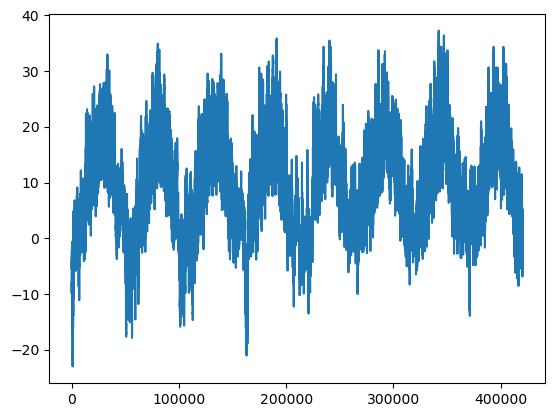

In [3]:
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)), temperature);

We can clearly see the yearly periodicity of the data. The data spans 8 years

Text(0.5, 1.0, 'First 10 days temperature')

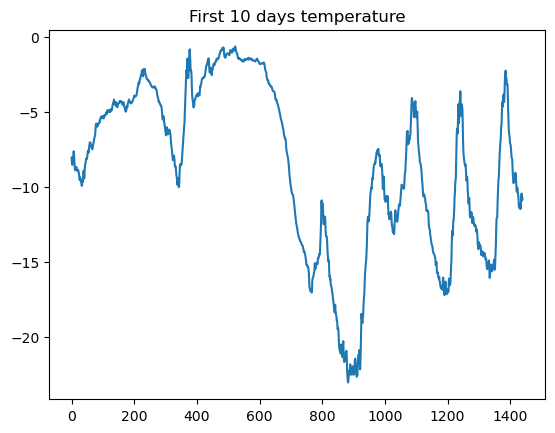

In [4]:
plt.plot(range(1440), temperature[:1440]);
plt.title("First 10 days temperature")

In this plot, we can see the daily periodicity of data, expecially in the last 4 days. Also can be concluded that the 10-day period must be from a fairly cold winter month

In [6]:
# getting split 50-25-25
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples: ", num_train_samples)
print("num_val_samples: ", num_val_samples)
print("num_test_samples: ", num_test_samples)

num_train_samples:  210225
num_val_samples:  105112
num_test_samples:  105114


# 2. Preparing data

### 2.1 Normalizing data

In [7]:
# each timeseries is on a diff scale
# normalize each timeseries independently

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### 2.2 Instantiating datasets for training, validation and testing

In [8]:
from tensorflow import keras

2023-04-08 16:54:29.505435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2023-04-08 16:54:38.505442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 16:54:38.505860: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
for samples, targets in train_dataset:
    print("samples shape: ", samples.shape)
    print("targets shape: ", targets.shape)    
    break

samples shape:  (256, 120, 14)
targets shape:  (256,)


# 3. Setting a baseline
a common-sense approach is to always
predict that the temperature 24 hours from now will be equal to the temperature
right now. Let’s evaluate this approach, using the mean absolute error (MAE) met-
ric

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


# 4. Trying a basic machine learning model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_dense.keras",
                                    save_best_only=True)
]

# use mse as loss as it smooth aroud zero -> better for gradient descent
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 61s 73ms/step - loss: 11.7820 - mae: 2.6503 - val_loss: 11.9871 - val_mae: 2.7496
Epoch 2/10
819/819 [==============================] - 62s 75ms/step - loss: 8.6618 - mae: 2.3154 - val_loss: 11.0277 - val_mae: 2.6269
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 8.0518 - mae: 2.2341 - val_loss: 10.6639 - val_mae: 2.5925
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 7.6617 - mae: 2.1791 - val_loss: 12.3275 - val_mae: 2.8044
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 7.3613 - mae: 2.1365 - val_loss: 11.5104 - val_mae: 2.7012
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 7.1462 - mae: 2.1045 - val_loss: 10.9518 - val_mae: 2.6314
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 6.9597 - mae: 2.0801 - val_loss: 12.5183 - val_mae: 2.8065
Epoch 8/10
819/819 [==============================] - 

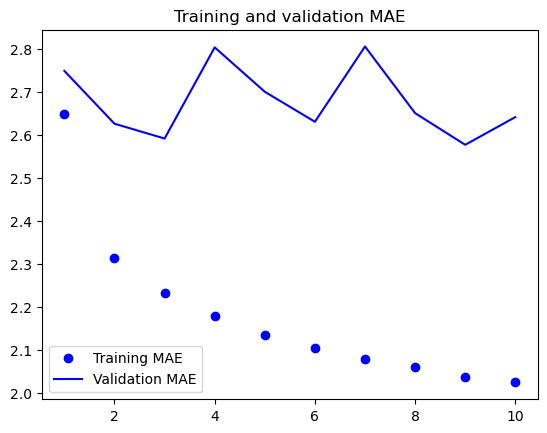

In [14]:
# plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 5. Trying a 1D convolutional model

We’ll pick an initial window
length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsam-
ple the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly:

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
        keras.callbacks.ModelCheckpoint("jena_conv.keras",
        save_best_only=True)
        ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 72s 87ms/step - loss: 21.7310 - mae: 3.6326 - val_loss: 17.7746 - val_mae: 3.3764
Epoch 2/10
819/819 [==============================] - 71s 86ms/step - loss: 14.5605 - mae: 3.0251 - val_loss: 15.3097 - val_mae: 3.1247
Epoch 3/10
819/819 [==============================] - 70s 85ms/step - loss: 13.3885 - mae: 2.8970 - val_loss: 14.8344 - val_mae: 3.0443
Epoch 4/10
819/819 [==============================] - 68s 83ms/step - loss: 12.6992 - mae: 2.8172 - val_loss: 15.7282 - val_mae: 3.1136
Epoch 5/10
819/819 [==============================] - 65s 79ms/step - loss: 12.1013 - mae: 2.7494 - val_loss: 15.0934 - val_mae: 3.0356
Epoch 6/10
819/819 [==============================] - 67s 81ms/step - loss: 11.5941 - mae: 2.6915 - val_loss: 15.3439 - val_mae: 3.0564
Epoch 7/10
819/819 [==============================] - 69s 84ms/step - loss: 11.1574 - mae: 2.6401 - val_loss: 14.6504 - val_mae: 2.9835
Epoch 8/10
819/819 [============================

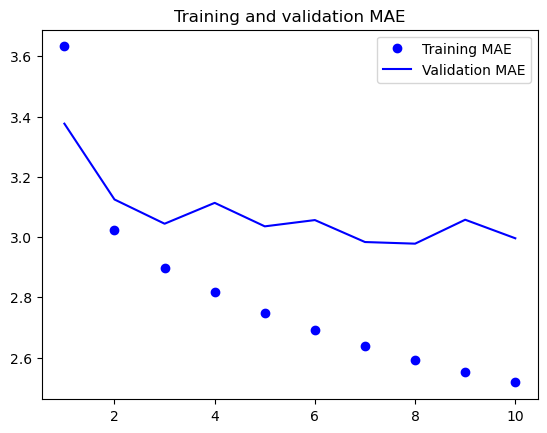

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 6. A first recurrent baseline

In [17]:
inputs = keras.Input(shape=(sequence_lengthuence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm.keras",
                                   save_best_only = True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data = val_dataset,
                   callbacks = callbacks)

model = keras.models.load_model("models/jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 165ms/step - loss: 39.0004 - mae: 4.5329 - val_loss: 11.6286 - val_mae: 2.5947
Epoch 2/10
819/819 [==============================] - 130s 158ms/step - loss: 10.6750 - mae: 2.5391 - val_loss: 9.7869 - val_mae: 2.4263
Epoch 3/10
819/819 [==============================] - 146s 179ms/step - loss: 9.4351 - mae: 2.3954 - val_loss: 9.7342 - val_mae: 2.4243
Epoch 4/10
819/819 [==============================] - 121s 147ms/step - loss: 8.8678 - mae: 2.3226 - val_loss: 10.2678 - val_mae: 2.5052
Epoch 5/10
819/819 [==============================] - 134s 163ms/step - loss: 8.4233 - mae: 2.2653 - val_loss: 9.9276 - val_mae: 2.4778
Epoch 6/10
819/819 [==============================] - 133s 162ms/step - loss: 8.0823 - mae: 2.2221 - val_loss: 10.0312 - val_mae: 2.4800
Epoch 7/10
819/819 [==============================] - 131s 159ms/step - loss: 7.8445 - mae: 2.1906 - val_loss: 9.9616 - val_mae: 2.4808
Epoch 8/10
819/819 [=======================

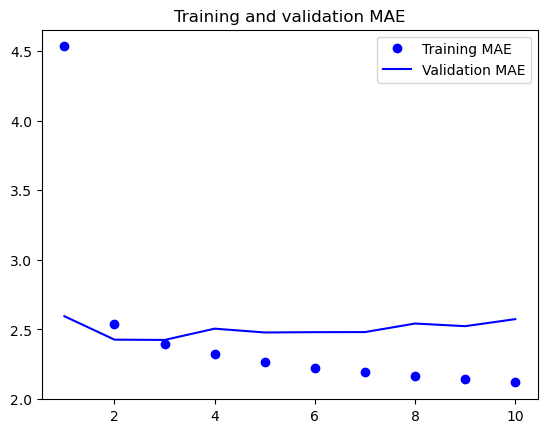

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

This model finally beats the deadline

### 6.1 Creating RNNs from scratch

### 6.1.1 Pseudocode RNN

In [ ]:
# initial state is zero
state_t = 0
# iterate throuigh sequence as elements
for input_t in sequence:
    # generate current output
    output_t = f(input_t, state_t)
    # current ouput becomes state for next timestep
    state_t = output_t

### 6.1.2 More detailed pseudocode for RNN

In [ ]:
state_t = 0
for input_t in sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

### 6.1.3 Naive numpy implementation of a simple RNN

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

## 6.2 A recurrent layer in keras

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
ouputs = keras.layers.SimpleRNN(16)(inputs)

In [23]:
# return_sequences specifies if we need the complete list of output sequences
# model that return complete output sequences:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [25]:
# stacking recurrent layers
inputs = keras.Input(shape=(steps, num_features))
x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(16, return_sequences=True)(x)
outputs = keras.layers.SimpleRNN(16)(x)

# 7. Using LSTM layers

### Pseudocode details for LSTM architecture: refer book

# 8. Advanced use of recurrent neural networks
* Recurrent dropout
* Stacking recurrent layers
* Bidirectional RNNs

## 8.1 Using recurrent dropout

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = keras.callbacks.ModelCheckpoint(
"models/jena_lstm_dropout.keras",
save_best_only=True)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs = 1,
                   validation_data=val_dataset,
                   callbacks=callbacks)

## 8.1 Using unrolling 

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

## 8.2 Stacking RNN layers
Training and evaluating a dropout-regularized stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.GRU(32, recurrent_dropout=0.5)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = keras.callbacks.ModelCheckpoint(
"models/jena_stacked_gru_dropout.keras",
save_best_only=True)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs = 1,
                   validation_data=val_dataset,
                   callbacks=callbacks)

# 8.3 Bidirectional RNNs

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs = 1,
                   validation_data=val_dataset,
                   callbacks=callbacks)